Kaggle에서 제공하는 Crowdflower Search Results Relevance data를 사용하여 검색 서비스 만족도 판별 모델을 개발한 과정을 정리해 봤습니다.


dacon에서 제공하는 데이터를 사용하여 객체 인식 알고리즘인 faster rcnn을 개발한 과정을 정리해 봤습니다.

In [7]:
import cv2
import matplotlib.pyplot as plt

In [25]:
image1 = cv2.imread('./test_img.jpg', cv2.COLOR_BGR2RGB)
img_ = image1[120:120+432, 100:100+768].copy()/255

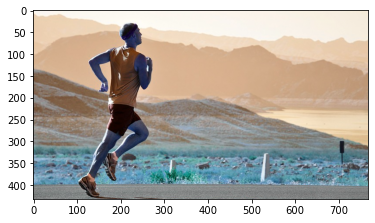

In [26]:
plt.imshow(img_)
plt.show()

먼저 human joint keypoint detection task의 동향에 대하여 알아보기 위하여 역대 SOTA를 달성한 논문들을 읽어 보았습니다.
결과로 여러가지 방식중 사람을 먼저 detection한뒤 keypoint를 추정하는 Top-down방식이 

하지만 안그래도 늦게 시작하였는데 논문을 읽으며 개발 과정을 탐구 하는데 시간을 너무 많이 허비 하여,
detection model만이라도 개발해보자하여 faster-rcnn을 적용하고 시간이 남는다면 mask rcnn을 적용하여 key-point를 추정하기로 계획을 변경하였습니다.

detection model을 개발해보는 것만으로도 좋은 경험이므로 




dacon에서 진행한 [모션 키포인트 검출 AI 경진대회](https://dacon.io/competitions/official/235701/overview/description/)의 데이터를 기반으로 객체 인식 모델을 개발한 과정을 정리해봤습니다.

먼저 human joint keypoint detection task의 동향에 대하여 알아보기 위하여 역대 SOTA를 달성한 논문들을 읽어 보았습니다. 

결과로 여러가지 방식중 사람을 먼저 detection한뒤 keypoint를 추정하는 Top-down방식을 설계하기 

가장 유명한 알고리즘중 하나인 faster-rcnn을 구현하기로 하였습니다.

(논문을 읽으며 개발 과정을 탐구 하는데 시간을 너무 많이 허비 하여, detection model만이라도 개발해보자하여 faster-rcnn을 적용하고 시간이 남는다면 mask rcnn을 적용하여 key-point를 추정하기로 계획을 변경하였습니다.)

아래는 faster rcnn 구현 코드와 설명입니다.
모든 코드는 google colab에서 구동하였습니다.

backbone은 resnet50을 사용하였습니다.
또한 이미지가 너무 크기 때문에 0.4배 하여 사용하였습니다.

## Bounding Box

### bounding box generator

먼저 dacon에서 제공하는 data는 key point 추정이므로 bounding box에 대한 라벨은없습니다. 

따라서 각 key point에서 x, y 좌표 최대, 최소값으로 bounding box를 설정 하기로 하였습니다.

하지만 key point data에서 단순히 최대 최소 값을 기준으로 bounding box를 설정하면 머리, 발, 손등이 잘리기 때문에 가로 세로를 확장하기로 하였습니다.

먼저 자세에 따라 최대 최소 값을 살펴 보고 bounding box를 확장하기 위한 기준을 잡기로 하였습니다.

1. y 최소값은 눈, 손(팔을 들고 있을때) 최댓값은 등(누워 있는 자세), 손 발(업드리거나 서있는 자세)
2. x 최대 최소 값은 손, 발, 눈(누워 있는 자세), 등 골반(구부린 자세의 옆모습)이 됩니다. 

각 자세에 따라 가로 세로 비율이 1~3배가 되고 누워서 두 팔을 편 자세일 경우 7배 까지 됩니다.
추가로 대부분 w가 길면 누워있는 경우, h가 길면 서 있는 경우임을 확인 하였습니다. 

결과로 다음과 같은 기준을 새웠습니다.
1. w가 길때, h가 길때 두 경우의 x, y에 곱해주는 비율을 다르게 할것
2. w, h의 비율이 3배 이상인 경우 팔을 들고 있는경우 이며 각각 확장해주는 값을 더 크게 설정할것
3. 비율이 비슷한 경우는 상체를 숙이고 있거나 벤치에 누워서 팔을 들어올린 경우가 있지만 위와 같이 처리하였을때 사람을 잘 포함하기 때문에 이 경우는 따로 처리 하지 않았습니다.

In [ ]:
def gt_generator(target):
    x_min = np.min(target[::2])
    x_max = np.max(target[::2])
    y_min = np.min(target[1::2])
    y_max = np.max(target[1::2])
    ratio = (x_max - x_min) / (y_max - y_min)

    y_max = y_max + (y_max - y_min)*.25 if ratio > 3 else y_max + (y_max - y_min)*.03  if ratio > 1 else y_max    
    y_min = y_min - (y_max - y_min)*.25 if ratio > 3 else y_min - (y_max - y_min)*.03  if ratio > 1 else y_min
    x_min = x_min - (x_max - x_min)*.03 if ratio > 3 else x_min - (x_max - x_min)*.05  if ratio > 1 else x_min
    x_max = x_max + (x_max - x_min)*.03 if ratio > 3 else x_max + (x_max - x_min)*.05  if ratio > 1 else x_max

    x_min = x_min - (x_max - x_min)*.25 if ratio < 1/3 else x_min - (x_max - x_min)*.03 if ratio < 1 else x_min
    x_max = x_max + (x_max - x_min)*.25 if ratio < 1/3 else x_max + (x_max - x_min)*.03 if ratio < 1 else x_max
    y_max = y_max + (y_max - y_min)*.03 if ratio < 1/3 else y_max + (y_max - y_min)*.05 if ratio < 1 else y_max
    y_min = y_min - (y_max - y_min)*.03 if ratio < 1/3 else y_min - (y_max - y_min)*.05 if ratio < 1 else y_min 

    ground_truth_x_min = x_min - (x_max - x_min)*.05
    ground_truth_x_max = x_max + (x_max - x_min)*.05
    ground_truth_y_min = y_min - (y_max - y_min)*.05
    ground_truth_y_max = y_max + (y_max - y_min)*.05

    ground_truth_w = ground_truth_x_max - ground_truth_x_min
    ground_truth_h = ground_truth_y_max - ground_truth_y_min
    ground_truth_x = ground_truth_w/2 + ground_truth_x_min
    ground_truth_y = ground_truth_h/2 + ground_truth_y_min
    return [ground_truth_x, ground_truth_y, ground_truth_w, ground_truth_h]

기준에 따라 가로 세로를 확장하고 비율이 극단적인 경우를 고려하여 추가로 10%의 확장을 적용하였습니다.

### Anchor box

anchor box를 설정하기 위하여 다음을 고려하며 ground truth bounding box의 분포를 그래프, 눈으로 확인하고 scales, ratio값을 설정 하였습니다.

1. ground truth bounding box의 넓이 분포
2. w, h의 길이 비
3. anchor의 갯수

결과로 5개의 scales, 5개의 ratio를 설정하였습니다.
즉 faster-rcnn에서 K = 5\*5 가 되었습니다.

In [ ]:
def anchor_box_generator(x, y, scales, ratio):
    anchor_boxes = []
    for scale in scales:
        for w, h  in ratio:
            w *= scale
            h *= scale     
            anchor_boxes.append([x, y, w, h])
    return anchor_boxes

def Anchor_Boxes(img_shape, scales, ratio):
    Ratio = 2**4
    w=img_shape[1]//Ratio
    h=img_shape[0]//Ratio
    
    anchor_boxes = []
    for x in range(img_shape[1]//w//2, img_shape[1], img_shape[1]//w):
        for y in range(img_shape[0]//h//2, img_shape[0], img_shape[0]//h):
            anchor_boxes.append(anchor_box_generator(x, y, scales, ratio))
    return np.array(anchor_boxes).reshape(-1, 4)

### out_boundaries_indxes

anchor box를 보면 이미지의 범위를 넘는 anchor가 상당수 존재합니다. 학습과정에서 이를 무시 하기 위해서 out_boundaries_indxes를 따로 계산하여 label을 생성할때 무시하도록 하였습니다.

In [2]:
bboxes = anchors_to_coordinates(anchor_boxes)
out_boundaries_indxes = (np.where(bboxes[:, 0] < 0) or np.where(bboxes[:, 2] < 0) or 
                         np.where(bboxes[:, 1] > img_shape[1]) or np.where(bboxes[:, 3] > img_shape[0]))[0]

## data

### label generator

anchor box를 설정하였으니 ground truth와 비교하여 모델을 훈련시킬 label을 생성합니다. 
논문과 같이 iou가 각 anchor box들과 ground truth의 iou가 0.7이상인 box를 P, 0.3 이하인 box를 N으로 두고 나머지는 고려 하지 않습니다.

이때 P와 N의 비율이 1:1이 되도록 설정하기 위하여 이미지당 label 갯수를 설정 32로 설정 하였습니다. 
이는 데이터에서 이미지당 검출해야하는 사람이 단 한명이며, 자세가 다양하기 때문입니다.

추가로 bounding box regression을 수행하기 위하여 좌표를 논문에서 소개된 함수를 통과 시켜주었습니다.

In [ ]:
def label_generator(GT, anchor_boxes, out_boundaries_indxes):
    cls_label = - np.ones(shape=(anchor_boxes.shape[0]))
    pos_iou_threshold = 0.7
    neg_iou_threshold = 0.3
    n_sample = 32
    pos_ratio = 0.5
    n_pos = int(pos_ratio * n_sample)
    
    ious = np.apply_along_axis(IoU_np, 0, GT, anchor_boxes=anchor_boxes)
    cls_label[ious >= pos_iou_threshold] = 1
    cls_label[ious < neg_iou_threshold] = 0
    cls_label[np.argmax(ious)] = 1
    cls_label[out_boundaries_indxes] = -1

    pos_index = np.where(cls_label == 1)[0]
    if len(pos_index) > n_pos:
        disable_index = np.random.choice(
            pos_index,
            size = (len(pos_index) - n_pos),
            replace=False
        )
        cls_label[disable_index] = -1

    n_neg = n_sample - np.sum(cls_label == 1)
    neg_index = np.where(cls_label == 0)[0]
    if len(neg_index) > n_neg:
        disable_index = np.random.choice(
            neg_index, 
            size = (len(neg_index) - n_neg),             
            replace = False
        )
        cls_label[disable_index] = -1

    reg_label = anchor_boxes * np.broadcast_to(tf.cast(cls_label > 0, tf.int32), (4, len(cls_label))).T
    indices = np.where(reg_label != 0)[0][::4]
    x, y, w, h = GT[0], GT[1], GT[2], GT[3]

    tx = (x - reg_label[indices][:, 0]) / (reg_label[indices][:, 2])
    ty = (y - reg_label[indices][:, 1]) / (reg_label[indices][:, 3])
    tw = np.log(w / reg_label[indices][:, 2]) 
    th = np.log(h / reg_label[indices][:, 3]) 
    reg_label[indices] = np.stack([tx, ty, tw, th]).T

    return cls_label, reg_label

### data augmentation

data augmentation은 dacon에 코드를 공유하여 주신 분이 계셔서 조금 수정하여 사용 하였습니다.  
아래 링크에서 확인 해주세요   
[date augmentation](https://dacon.io/competitions/official/235701/codeshare/2383?page=2&dtype=recent)

### data load

In [ ]:
def traingtGenerator():
    Rx, Ry = 0.4, 0.4
    size = [int(image_size[0] * Rx), int(image_size[1] * Ry)]

    for i in range(len(train)):
        img = tf.io.read_file(train_val_dir + 'train/' + train['image'].iloc[i]) 
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.resize(img, size) 
        img = img/255                         
        target = list(train.iloc[:,1:49].iloc[i,:])
        gt = gt_generator(target)
        cls_label, reg_label = label_generator(gt, anchor_boxes, out_boundaries_indxes)

        yield img, (cls_label, reg_label, gt)

In [ ]:
batch_size = 16
train_dataset = tf.data.Dataset.from_generator(
    traingtGenerator,
    output_signature = (
            tf.TensorSpec(shape=(size[0], size[1], 3)),
            (
                tf.TensorSpec(shape=(len(anchor_boxes))),
                tf.TensorSpec(shape=(len(anchor_boxes),4)),
                tf.TensorSpec(shape=(4))
            )
        )
).batch(batch_size).prefetch(batch_size*2)

데이터 로드는 data 함수를 통하여 모델의 input으로 들어가게 하였습니다.

## region proposal network

### backborn

In [11]:
def get_base(img_size, model='resnet50'):
    if model=='vgg':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("block5_conv3")
    elif model == 'resnet101':
        base_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("conv4_block23_out")
    elif model == 'resnet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("conv4_block6_out")  
    else:
        raise Exception('vgg, resnet')

    base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)
    return base_model

backborn은 imagenet에서 훈련된 VGG16, resnet50, resnet101을 사용합니다.  
성능차는 VGG16 < resnet50 < resnet101 이지만 resnet101은 무겁기 때문에 resnet50을 기본으로 사용하였습니다.

### RPN

In [5]:
class RPN(tf.keras.models.Model):
    def __init__(self, img_size, anchor_boxes, k=5*5, n_sample=32, backbone='resnet50', rpn_lambda=10**3, **kwargs):
        super(RPN, self).__init__(**kwargs)
        self.img_size = img_size
        self.anchor_boxes = anchor_boxes
        self.num_of_anchor = len(self.anchor_boxes)
        self.n_sample = n_sample
        self.k = k
        self.backbone = backbone
        self.rpn_lambda = rpn_lambda

        self.base_model = get_base(self.img_size, model=self.backbone)
        self.window = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name='window')
        self.window_bn = tf.keras.layers.BatchNormalization(name='window_bn')
        self.window_relu = tf.keras.layers.ReLU(name='window_relu')

        self.bbox_reg = tf.keras.layers.Conv2D(filters=self.k*4, kernel_size=1, name='bbox_reg')
        self.bbox_reg_reshape = tf.keras.layers.Reshape((-1, 4), name='reg_out')
        
        self.cls = tf.keras.layers.Conv2D(filters=self.k, kernel_size=1, activation='sigmoid', name='cls')
        self.cls_reshape = tf.keras.layers.Reshape((-1, 1), name='cls_out')

    def compile(self, optimizer, **kwargs):
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')
        self.optimizer = optimizer
        super(RPN, self).compile(**kwargs)
    
    def Cls_Loss(self, y_true, y_pred):
        indices = tf.where(tf.not_equal(y_true, tf.constant(-1.0, dtype=tf.float32)))
        target = tf.gather_nd(y_true, indices)
        output = tf.gather_nd(y_pred, indices)
        return tf.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM)(target, output)/self.n_sample

    def Reg_Loss(self, y_true, y_pred):
        indices = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
        return tf.losses.Huber(reduction=tf.losses.Reduction.SUM)(y_true[indices], y_pred[indices])/self.num_of_anchor

    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        
        with tf.GradientTape() as tape:
            cls, bbox_reg, _ = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg)
            losses = cls_loss + self.rpn_lambda * reg_loss
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'rpn_loss': self.loss_tracker.result()}

    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        
        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg)
        losses = cls_loss + self.rpn_lambda * reg_loss

        self.test_loss_tracker.update_state(losses)
        return {'rpn_loss_val': self.test_loss_tracker.result()}

    @tf.function
    def bbox_regression(self, boxes):
        tx = (boxes[:, :, 0] - self.anchor_boxes[:, 0]) / self.anchor_boxes[:, 2]
        ty = (boxes[:, :, 1] - self.anchor_boxes[:, 1]) / self.anchor_boxes[:, 3]
        tw = tf.math.log(tf.maximum(boxes[:, :, 2], np.finfo(np.float64).eps) / self.anchor_boxes[:, 2])
        th = tf.math.log(tf.maximum(boxes[:, :, 3], np.finfo(np.float64).eps) / self.anchor_boxes[:, 3])
        return tf.stack([tx, ty, tw, th], -1)

    @tf.function
    def inverse_bbox_regression(self, boxes):
        gx = self.anchor_boxes[:, 2] * boxes[:, :, 0] + self.anchor_boxes[:, 0]
        gy = self.anchor_boxes[:, 3] * boxes[:, :, 1] + self.anchor_boxes[:, 1]
        gw = self.anchor_boxes[:, 2] * tf.exp(boxes[:, :, 2])
        gh = self.anchor_boxes[:, 3] * tf.exp(boxes[:, :, 3])
        return tf.stack([gx, gy, gw, gh], axis=-1)
        
    def call(self, inputs):
        feature_extractor = self.base_model(inputs)
        intermediate = self.window(feature_extractor)
        intermediate = self.window_bn(intermediate)
        intermediate = self.window_relu(intermediate)

        cls = self.cls(intermediate)
        cls = self.cls_reshape(cls)
        bbox_reg = self.bbox_reg(intermediate)
        bbox_reg = self.bbox_reg_reshape(bbox_reg)
        bbox_reg = self.bbox_regression(bbox_reg)
        return cls, bbox_reg, feature_extractor

faster rcnn의 region proposal network 구현입니다.

각 anchor box에서 object가 존재하는지 판단하는 cls branch와 object가 존재한다면 bounbing박스를 예측하는 bbox_reg branch를 이루어져 있습니다. 

cls의 경우 위에서 -1로 설정한 anchor는 무시하고 계산합니다.  
bbox reg의 경우 iou가 0.7 이상인 값에서만 계산 합니다.

loss는 논문에서 소개한 함수를 사용하였습니다.
또한 rpn_lambda는 이미지당 label의 갯수인 n_sample과 anchor box의 갯수인 num_of_anchor의 비율인 10\*\*3으로 설정 하였습니다.

### get candidate layer

In [ ]:
class get_candidate_layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(get_candidate_layer, self).__init__(**kwargs)

    def anchors_clip(self, boxes, size=(432, 768)):    
        x1 = boxes[:, :, 0] - boxes[:, :, 2]/2
        x2 = boxes[:, :, 0] + boxes[:, :, 2]/2
        y1 = boxes[:, :, 1] - boxes[:, :, 3]/2
        y2 = boxes[:, :, 1] + boxes[:, :, 3]/2
        
        x1 = tf.clip_by_value(x1, 0, size[1])
        x2 = tf.clip_by_value(x2, 0, size[1])
        y1 = tf.clip_by_value(y1, 0, size[0])
        y2 = tf.clip_by_value(y2, 0, size[0])

        w = x2 - x1
        h = y2 - y1
        x = x1 + w/2
        y = y1 + h/2
        return tf.stack([x, y, w, h], axis=-1)

    def call(self, x):
        scores, rps, n_pre_nms = x
        rois = self.anchors_clip(rps)

        oobw = tf.expand_dims(tf.cast(tf.math.greater(rois[:, :, 2], 16), tf.float32), -1)
        oobh = tf.expand_dims(tf.cast(tf.math.greater(rois[:, :, 3], 16), tf.float32), -1)
        scores = tf.math.multiply(scores, oobw)
        scores = tf.math.multiply(scores, oobh)

        orders = tf.argsort(scores, direction='DESCENDING', axis=1)[:, :n_pre_nms]
        rois = tf.gather_nd(rois, orders, batch_dims=1)
        scores = tf.gather_nd(scores, orders, batch_dims=1)
        return rois, scores

rpn을 통과하여 나온 값에 NMS를 적용하기 전에 아래의 과정을 거쳐 box들을 걸러냅니다.
1. x, y 좌표가 이미지의 사이즈를 넘어가는 경우 clip
2. 가로, 세로의 길이가 16 이하인 box들 제외
3. confidence score가 높은 순으로 정렬후 상위 n_pre_nms개의 box들만 추출

### non maximum suppression

In [ ]:
class NMS(tf.keras.layers.Layer):
    def __init__(self, iou_threshold=0.7, **kwargs):
        self.iou_threshold = iou_threshold
        super(NMS, self).__init__(**kwargs)

    def call(self, inputs):
        rois, scores, max_output_size = inputs
        selected_indices_padded = tf.image.non_max_suppression_padded(
            rois, 
            tf.squeeze(scores), 
            max_output_size=max_output_size,
            iou_threshold=0.7,
            pad_to_max_output_size=True
        )[0]
        nms = tf.gather(rois, selected_indices_padded, batch_dims=1)
        return nms

get_candidate_layer를 통과하여 나온 후보 지역들을 non maximum suppression을 통하여 다시 max_output_size개만 추출합니다.

### RoI pooling

In [ ]:
class RoIpool(tf.keras.layers.Layer):
    def __init__(self, pool_size=7, **kwargs):
        self.pool_size = pool_size
        super(RoIpool, self).__init__(**kwargs)

    def cal_rois_ratio(self, nmses, size=[432, 768]):
        x1 = (nmses[:, :, 0] - nmses[:, :, 2]/2)/size[1]
        x2 = (nmses[:, :, 0] + nmses[:, :, 2]/2)/size[1]
        y1 = (nmses[:, :, 1] - nmses[:, :, 3]/2)/size[0]
        y2 = (nmses[:, :, 1] + nmses[:, :, 3]/2)/size[0]
        return tf.stack([y1, x1, y2, x2], axis=-1)

    def call(self, inputs):
        feature_map, nmses = inputs
        n_channel = feature_map.shape[-1]
        batch_size = nmses.shape[0]
        num_rois = nmses.shape[1]
        nmses = self.cal_rois_ratio(nmses)
        rois = tf.image.crop_and_resize(
            feature_map, 
            tf.reshape(nmses, (-1, 4)), 
            box_indices=tf.convert_to_tensor([i for i in range(batch_size) for _ in range(num_rois)]), 
            crop_size=[self.pool_size, self.pool_size]
        )
        return tf.reshape(rois, shape=(batch_size, num_rois, self.pool_size, self.pool_size, n_channel))

NMS를 통해 나온 지역들은 classifier의 inputs으로 입력되기 위해 roi pooling을 합니다. 
mask rcnn구현을 찾아보던중 tf.image.crop_and_resize함수가 roi align의 수행과 같은 process라고 하여 간단히 구현 할 수 있었습니다.

## Fast rcnn 

###  label generator

classifier를 구현하기 전에 다시 한번 label generator를 구현하여야 합니다.

In [ ]:
def classifier_label_generator(nms, gts, valid=False):
    num_roi = 128
    pos_ratio = .5
    num_pos = int(num_roi * pos_ratio)
    num_neg = int(num_roi - num_pos)
    ious = get_iou(nms, gts)
    pos_order = tf.argsort(ious * tf.cast(tf.math.greater_equal(ious, 0.5), tf.float64), direction='DESCENDING', axis=1)[:, :num_pos]
    neg_order = tf.argsort(ious * tf.cast(tf.math.less(ious, 0.5), tf.float64), direction='DESCENDING', axis=1)[:, :num_neg]
    
    if not valid:
        neg_cnt = tf.reduce_min(tf.math.count_nonzero(ious * tf.cast(tf.math.less(ious, 0.5), tf.float64), axis=1))
        neg_order = tf.argsort(ious * tf.cast(tf.math.less(ious, 0.5), tf.float64), direction='DESCENDING', axis=1)[:, :neg_cnt]
        indices = tf.range(start=0, limit=neg_cnt, dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)
        neg_order = tf.gather(neg_order, shuffled_indices, axis=1)[:, :num_neg]

    cls_labels = tf.concat([tf.ones_like(pos_order), tf.zeros_like(neg_order)], axis=1)
    label_order = tf.concat([pos_order, neg_order], axis=1)
    P_boxes = tf.gather(nms, label_order, batch_dims=1)
    
    tx = (gts[:, :1] - P_boxes[:, :, 0]) / P_boxes[:, :, 2]
    ty = (gts[:, 1:2] - P_boxes[:, :, 1]) / P_boxes[:, :, 3]
    tw = tf.math.log(gts[:, 2:3] / P_boxes[:, :, 2]) 
    th = tf.math.log(gts[:, 3:] / P_boxes[:, :, 3]) 
    tf.stack([tx, ty, tw, th], axis=-1)
    box_labels = tf.stack([tx, ty, tw, th], axis=-1)
    return box_labels, cls_labels, P_boxes

confidence score를 기준으로 rpn과 nms를 통과한 box들의 iou를 계산하여 0.5 이상은 P, 이하는 N으로 설정합니다.
마찬가지로 bounding box regression을 위해 좌표 변환 함수도 통과 시켜주었습니다.

여기서 논문에서는 25% P를 하였지만 저는 50% 로 하였습니다. 
이는 단! 한명의 사람만 검출하는 과정 + 고정된 위치로 인해 rpn에서 특정 위치에 많은 box들을 추천하게 훈련되므로 N인 지역의 중복도를 고려한 조치 입니다.

### classifier

In [ ]:
class Classifier(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super(Classifier, self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(2048, kernel_size=(7, 7), name='conv')
        self.bn = tf.keras.layers.BatchNormalization(name='conv_bn')
        self.relu = tf.keras.layers.ReLU(name='conv_relu')
        self.flatten = tf.keras.layers.Flatten(name='flatten')

        self.dense1 = tf.keras.layers.Dense(1024, name='dense1')
        self.bn1 = tf.keras.layers.BatchNormalization(name='dense1_bn')
        self.relu1 = tf.keras.layers.ReLU(name='dense1_relu')

        self.dense2 = tf.keras.layers.Dense(1024, name='dense2')
        self.bn2 = tf.keras.layers.BatchNormalization(name='dense2_bn')
        self.relu2 = tf.keras.layers.ReLU(name='dense2_relu')

        self.cls_dense = tf.keras.layers.Dense(256, name='cls_dense')
        self.cls_bn = tf.keras.layers.BatchNormalization(, name='cls_bn')
        self.cls_relu = tf.keras.layers.ReLU(name='cls_relu')
        self.cls = tf.keras.layers.Dense(1, activation='sigmoid', name='cls_out')

        self.bbox_dense = tf.keras.layers.Dense(256, name='bbox_dense')
        self.bbox_bn = tf.keras.layers.BatchNormalization(name='bbox_bn')
        self.bbox_relu = tf.keras.layers.ReLU(name='bbox_relu')
        self.bbox_reg = tf.keras.layers.Dense(4, activation='relu', name='bbox_out')

    def compile(self, optimizer):
        super(Classifier, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')
    
    def Cls_Loss(self, y_true, y_pred):
        return tf.losses.BinaryCrossentropy()(y_true, y_pred)

    def Reg_Loss(self, y_true, y_pred, indices):
        return tf.losses.Huber()(y_true[indices], y_pred[indices])

    @tf.function
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        indices = tf.not_equal(y_cls, 0)
        
        with tf.GradientTape() as tape:
            cls, bbox_reg, _ = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg, indices)
            losses = cls_loss + reg_loss 
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'classifier_loss': self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        indices = tf.not_equal(y_cls, 0)

        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg, indices)
        losses = cls_loss + reg_loss 

        self.test_loss_tracker.update_state(losses)
        return {'classifier_loss_val': self.test_loss_tracker.result()}

    
    def bbox_regression(self, bbox, nmses):
        tx = (bbox[:, :, 0] - nmses[:, :, 0]) / nmses[:, :, 2]
        ty = (bbox[:, :, 1] - nmses[:, :, 1]) / nmses[:, :, 3]
        tw = tf.math.log(tf.maximum(bbox[:, :, 2], np.finfo(np.float64).eps) / nmses[:, :, 2])
        th = tf.math.log(tf.maximum(bbox[:, :, 3], np.finfo(np.float64).eps) / nmses[:, :, 3])
        return tf.stack([tx, ty, tw, th], -1)

    @staticmethod
    def inverse_bbox_regression(bbox, nmses):
        gx = nmses[:, :, 2] * bbox[:, :, 0] + nmses[:, :, 0]
        gy = nmses[:, :, 3] * bbox[:, :, 1] + nmses[:, :, 1]
        gw = nmses[:, :, 2] * tf.exp(bbox[:, :, 2])
        gh = nmses[:, :, 3] * tf.exp(bbox[:, :, 3])
        return tf.stack([gx, gy, gw, gh], -1)

    @tf.function
    def call(self, inputs, training=False):
        rois, nms = inputs

        cls_x = tf.keras.layers.TimeDistributed(self.conv)(rois)
        cls_x = tf.keras.layers.TimeDistributed(self.bn)(cls_x)
        cls_x = tf.keras.layers.TimeDistributed(self.relu)(cls_x)
        cls_x = tf.keras.layers.TimeDistributed(self.flatten)(cls_x)

        cls_x = tf.keras.layers.TimeDistributed(self.dense1)(cls_x)
        cls_x = tf.keras.layers.TimeDistributed(self.bn1)(cls_x)
        cls_x = tf.keras.layers.TimeDistributed(self.relu1)(cls_x)
        
        cls_x = tf.keras.layers.TimeDistributed(self.dense2)(cls_x)
        cls_x = tf.keras.layers.TimeDistributed(self.bn2)(cls_x)
        feature_vector = tf.keras.layers.TimeDistributed(self.relu2)(cls_x)

        cls_x = tf.keras.layers.TimeDistributed(self.cls_dense)(feature_vector)
        cls_x = tf.keras.layers.TimeDistributed(self.cls_bn)(cls_x)
        cls_x = tf.keras.layers.TimeDistributed(self.cls_relu)(cls_x)

        bbox_x = tf.keras.layers.TimeDistributed(self.bbox_dense)(feature_vector)
        bbox_x = tf.keras.layers.TimeDistributed(self.bbox_bn)(bbox_x)
        bbox_x = tf.keras.layers.TimeDistributed(self.bbox_relu)(bbox_x)

        clss = tf.keras.layers.TimeDistributed(self.cls)(cls_x)
        bbox = tf.keras.layers.TimeDistributed(self.bbox_reg)(bbox_x)
        bbox_reg = self.bbox_regression(bbox, nms)

        return clss, bbox_reg, nms

Classifier는 각 이미지당 128개의 roi가 존재 하기 때문에 TimeDistributed를 통하여 구현하였습니다.

전체 적인 구조는 논문을 따르지만 rcnn에서 classifer는 object별로 confidence score와 bounding box regression을 수행하는데 주어진 데이터와 task는 단 한명의 사람만 검출하면 되므로 rpn과 비슷한 과정을 거칩니다. 

하이퍼파라미터 탐색과 batch norm을 추가하여 훈련에 안정성을 주었습니다.

## Faster RCNN

In [ ]:
class Faster_RCNN(tf.keras.models.Model):
    def __init__(self, img_size, anchor_boxes, k, n_sample, backbone, rpn_lambda, pool_size, **kwargs):
        super(Faster_RCNN, self).__init__(*kwargs)
        self.img_size = img_size
        self.anchor_boxes = anchor_boxes
        self.k = k
        self.n_sample = n_sample
        self.backbone = backbone
        self.rpn_lambda = rpn_lambda
        self.pool_size = pool_size
        self.n_train_pre_nms = 6000
        self.n_train_post_nms = 1000
        self.n_test_pre_nms = 3000
        self.n_test_post_nms = 128
        self.iou_threshold = 0.7

        self.rpn = RPN(
            img_size= self.img_size, 
            anchor_boxes=self.anchor_boxes, 
            k=self.k, 
            n_sample=self.n_sample, 
            backbone=self.backbone, 
            rpn_lambda=self.rpn_lambda,
            name='rpn'
            )
        self.get_candidate = get_candidate_layer(name='get_candidate')
        self.get_nms = NMS(iou_threshold=self.iou_threshold, name='get_nms')
        self.roipool = RoIpool(pool_size=self.pool_size, name='roipool')
        self.classifier = Classifier(name='classifier')

    def compile(self, rpn_optimizer, classifier_optimizer):
        self.rpn.compile(optimizer=rpn_optimizer)
        self.classifier.compile(optimizer=classifier_optimizer)
        super(Faster_RCNN, self).compile()

    def call(self, inputs):
        scores, rps, feature_map = self.rpn(inputs)
        rps = self.rpn.inverse_bbox_regression(rps)
        candidate_area, scores = self.get_candidate((scores, rps, self.n_test_pre_nms))
        nms = self.get_nms((candidate_area, scores, self.n_test_post_nms))
        rois = self.roipool((feature_map, nms))
        cls, bbox_reg, nms = self.classifier((rois, nms))
        predict = self.classifier.inverse_bbox_regression(bbox_reg, nms)
        return cls, predict

rpn, roipooling, nms, classifier를 합친 Faster_RCNN을 구현하였습니다. training stage가 나누어져 있어 train_step을 따로 구현하여 훈련되도록 하였습니다.

### train step

In [ ]:
def frcnn_train_step(model, train_dataset, train_stage, epochs=1, valid_dataset=None, change_lr=False, rpn_lr=None, cls_lr=None):
    if change_lr:
        if rpn_lr:
            tf.keras.backend.set_value(model.rpn.optimizer.learning_rate, rpn_lr)
        if cls_lr:
            tf.keras.backend.set_value(model.classifier.optimizer.learning_rate, cls_lr)

    if train_stage == 1:
        print('Train RPNs \n')
        model.rpn.trainable = True
        model.classifier.trainable = False
    elif train_stage == 2:
        print('Train Fast R-CNN using the proposals from RPNs \n')
        model.rpn.trainable = False
        model.rpn.base_model.trainable = True
        model.classifier.trainable = True
    elif train_stage == 3:
        print('Fix the shared convolutional layers and fine-tune unique layers to RPN \n')
        model.rpn.trainable = True
        model.rpn.base_model.trainable = False
        model.classifier.trainable = False
    elif train_stage == 4:
        print('Fine-tune unique layers to Fast R-CNN \n')
        model.rpn.trainable = False
        model.classifier.trainable = True

    max_step = 'Unknown'
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"epoch {epoch+1}/{epochs}")
        display_loss = display("Training loss (for one batch) at step 0 : 0", display_id=True)
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            start = time.time()
            y_cls_rpn, y_reg_rpn, gts = y_batch_train
            
            if train_stage == 1 or train_stage == 3:
                result = model.rpn.train_step((x_batch_train, (y_cls_rpn, y_reg_rpn)))
                losses = round(float(result['rpn_loss'].numpy()), 5)
            else:
                scores, rps, feature_map = model.rpn(x_batch_train, training=False)
                if train_stage == 2:
                    model.rpn.train_step((x_batch_train, (y_cls_rpn, y_reg_rpn)))
                rps = model.rpn.inverse_bbox_regression(rps)
                candidate_area, scores = model.get_candidate((scores, rps, model.n_train_pre_nms))
                nms = model.get_nms((candidate_area, scores, model.n_train_post_nms))
                box_labels, cls_labels, nms = classifier_label_generator(nms, gts)
                rois = model.roipool((feature_map, nms))
                result = model.classifier.train_step(((rois, nms), (cls_labels, box_labels)))
                losses = round(float(result['classifier_loss'].numpy()), 5)

            display_loss.update(f"Training loss at step {step}/{max_step} : {losses} - {round(time.time() - start, 4)}sec/step - {time.strftime('%Hh%Mm%Ss', time.gmtime(time.time()-epoch_start))}/epoch")
        max_step = step
        display_loss.update(f"Training loss at step {step}/{max_step} : {losses} - {round(time.time()-start, 4)}sec/step - {time.strftime('%Hh%Mm%Ss', time.gmtime(time.time()-epoch_start))}/epoch")

        if valid_dataset is not None:
            display_loss_valid = display("validation loss : 0", display_id=True)
            for x_batch_test, y_batch_test in valid_dataset:
                y_cls_rpn, y_reg_rpn, gts = y_batch_test

                if train_stage == 1 or train_stage == 3:
                    result = model.rpn.test_step((x_batch_test, (y_cls_rpn, y_reg_rpn)))
                    losses = round(float(result['rpn_loss_val'].numpy()), 5)
                else:
                    scores, rps, feature_map = model.rpn.predict(x_batch_test)
                    rps = model.rpn.inverse_bbox_regression(rps)
                    candidate_area, scores = model.get_candidate((scores, rps, model.n_test_pre_nms))
                    nms = model.get_nms((candidate_area, scores, model.n_test_post_nms))
                    box_labels, cls_labels, nms = classifier_label_generator(nms, gts, valid=True)
                    rois = model.roipool((feature_map, nms))
                    result = model.classifier.test_step(((rois, nms), (cls_labels, box_labels)))
                    losses = round(float(result['classifier_loss_val'].numpy()), 5)
                
            display_loss_valid.update(f"validation loss : {losses}")

    return model

train stage는 다음 4단계로 구성됩니다.
1. RPNs 훈련합니다.
2. rpn는 고정하고 shared convolutional layer를 훈련합니다.
3. shared convolutional layers는 고정하고 RPN을 훈련합니다.
4. Fast R-CNN부분만 훈련합니다.

아래는 각 훈련을 마치고 제공된 데이터 이외의 사진을 적용시킨 결과입니다.